<a href="https://colab.research.google.com/github/konamilk/mlb-player-digital-engagement-forecasting/blob/main/mlb_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training

In [ ]:
import sys
from pathlib import Path

In [ ]:
# # Install_LightGBM_with_GPU
# if 'google.colab' in sys.modules:
#     ! git clone --recursive https://github.com/Microsoft/LightGBM

#     %cd /content/LightGBM
#     ! mkdir -p build

#     %cd build
#     ! cmake -DUSE_GPU=1 /content/LightGBM
#     ! make -j$(nproc)
#     ! sudo apt-get -y install python-pip
#     ! sudo -H pip install setuptools pandas numpy scipy scikit-learn -U

#     %cd /content/LightGBM/python-package
#     ! sudo python setup.py install --precompile

#     %cd /content/

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from functools import reduce
from tqdm import tqdm
import lightgbm as lgbm
import datetime
import gc
# if 'google.colab' in sys.modules:
#     !pip install git+https://github.com/pfnet-research/xfeat.git > /dev/null
# else:
#     !pip install ../input/xfeatwhl/xfeat-0.1.1-py3-none-any.whl > /dev/null

In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = Path('/content/input/mlb-player-digital-engagement-forecasting')
    TRAIN_DIR = Path('/content/input/mlb-pdef-train-dataset')
    DATASET_DIR = Path('/content/input/mlbpreprocessdataset')
    OUTPUT_DIR = Path('/content/output')
elif 'kaggle_web_client' in sys.modules:
    BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
    TRAIN_DIR = Path('../input/mlb-pdef-train-dataset')
    DATASET_DIR = Path('../input/mlbpreprocessdataset')
    OUTPUT_DIR = Path('/kaggle/working')

Mounted at /content/drive


In [ ]:
if 'google.colab' in sys.modules:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle
    !chmod 600 ~/.kaggle/kaggle.json
    !pip install kaggle > /dev/null
    !mkdir input
    # original datasets
    !kaggle competitions download -c mlb-player-digital-engagement-forecasting  > /dev/null
    !mkdir input/mlb-player-digital-engagement-forecasting
    !unzip -o '*.zip' -d ./input/mlb-player-digital-engagement-forecasting  > /dev/null
    !mv *.csv ./input/mlb-player-digital-engagement-forecasting
    !rm *.zip
    # # MLB_PDEF_train_dataset
    # !kaggle datasets download -d columbia2131/mlb-pdef-train-dataset  > /dev/null
    # !mkdir input/mlb-pdef-train-dataset
    # !unzip -o '*.zip' -d ./input/mlb-pdef-train-dataset  > /dev/null
    # !rm *.zip
    # # my preprocessed dataset
    # !kaggle datasets download -d pinana/mlbpreprocessdataset > /dev/null
    # !mkdir input/mlbpreprocessdataset
    # !unzip -o '*.zip' -d ./input/mlbpreprocessdataset  > /dev/null
    # !rm *.zip

100% 59.0/59.0 [00:00<00:00, 20.4kB/s]
100% 443k/443k [00:00<00:00, 60.1MB/s]
100% 824/824 [00:00<00:00, 752kB/s]
100% 173k/173k [00:00<00:00, 55.5MB/s]
100% 3.68k/3.68k [00:00<00:00, 3.44MB/s]
100% 470M/470M [00:11<00:00, 43.3MB/s]
100% 191k/191k [00:00<00:00, 200MB/s]
100% 3.96M/3.96M [00:00<00:00, 131MB/s]
100% 820k/820k [00:00<00:00, 50.2MB/s]

2 archives were successfully processed.


In [ ]:
df_origin = pd.read_csv(BASE_DIR / 'train.csv')
df = df_origin[df_origin.date >= 20210401]
df.drop('nextDayPlayerEngagement', axis=1)
df.set_index('date',inplace=True)
df.head(5)

In [ ]:
class TestDataset(object):
  def __init__(self, batch_size=5):
    self.current = 0
    self.batch_size = batch_size
    _df = pd.read_csv(BASE_DIR/ 'train.csv')
    self.df_test = _df[_df['date'] >= 20210401]

  def __iter__(self):
    return self

  def __next__(self):
    start = self.current * self.batch_size
    end = (self.current + 1) * self.batch_size
    self.current += 1

    if start >= self.df_test.shape[0]:
      raise StopIteration()

    # df_example_test
    df_example_test = self.df_test[start:end].drop('nextDayPlayerEngagement', axis=1)
    df_example_test.set_index('date', inplace=True)

    # df_example_sample_submission
    df_example_sample_submission = pd.DataFrame()
    for index, row in self.df_test[start:end].iterrows():
        _date = row.date
        _nextDayPlayerEngagement = pd.DataFrame(eval(row.nextDayPlayerEngagement))
        _nextDayPlayerEngagement['date'] = _date
        df_example_sample_submission = pd.concat([df_example_sample_submission, _nextDayPlayerEngagement], axis=0)
    df_example_sample_submission['date_playerId'] = df_example_sample_submission['engagementMetricsDate'].str.replace('-', '') + '_' + df_example_sample_submission['playerId'].astype(str)
    df_example_sample_submission.drop(['engagementMetricsDate', 'playerId'], axis=1, inplace=True)
    df_example_sample_submission.target1 = 0.0
    df_example_sample_submission.target2 = 0.0
    df_example_sample_submission.target3 = 0.0
    df_example_sample_submission.target4 = 0.0
    df_example_sample_submission.set_index('date', inplace=True)
    df_example_sample_submission = df_example_sample_submission[['date_playerId','target1','target2','target3','target4']]
    
    return df_example_test, df_example_sample_submission



In [ ]:
iter_test = TestDataset()

In [ ]:
null = np.nan
true = True
false = False

player_axis_cols = ['playerId', 'primaryPositionCode', 'teamId', 'statusCode', 'playerFollowers']
team_axis_cols = ['teamId', 'leagueId', 'divisionId', 'venueId', 'teamFollowers']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

standings_cols = ['divisionId', 'teamId', 'streakCode', 'divisionRank', 'leagueRank',
       'wildCardRank', 'leagueGamesBack', 'sportGamesBack',
       'divisionGamesBack', 'wins', 'losses', 'pct', 'runsAllowed',
       #'runsScored',
       'divisionChamp', 'divisionLeader', 'wildCardLeader',
       'eliminationNumber', 'wildCardEliminationNumber', 'homeWins',
       'homeLosses', 'awayWins', 'awayLosses', 'lastTenWins', 'lastTenLosses',
       'extraInningWins', 'extraInningLosses', 'oneRunWins', 'oneRunLosses',
       'dayWins', 'dayLosses', 'nightWins', 'nightLosses', 'grassWins',
       'grassLosses', 'turfWins', 'turfLosses', 'divWins', 'divLosses',
       'alWins', 'alLosses', 'nlWins', 'nlLosses', 'xWinLossPct']

class InternalStates():
    def __init__(self):
        self.player_axis = pd.DataFrame(columns=player_axis_cols)
        players = pd.read_csv(BASE_DIR / 'players.csv')[['playerId', 'primaryPositionCode']]
        self.player_axis = pd.concat([self.player_axis , players], axis=0)
        
        self.team_axis = pd.DataFrame(columns=team_axis_cols)
        teams = pd.read_csv(BASE_DIR / 'teams.csv')[['id', 'leagueId', 'divisionId', 'venueId']].rename(columns= {'id': 'teamId'})
        self.team_axis = pd.concat([self.team_axis, teams], axis=0)


        self.seasons = pd.read_csv(BASE_DIR / 'seasons.csv')
    
    def update(self, row: pd.Series):
        if row['rosters'] == row['rosters']:
            self.player_axis = pd.merge(
                self.player_axis,
                pd.DataFrame(eval(row['rosters']))[['playerId', 'teamId', 'statusCode']],
                on=['playerId'],
                how='left',
                suffixes=['_old', '']
            )
            self.player_axis['teamId'] = self.player_axis['teamId'].combine_first(self.player_axis['teamId_old'])
            self.player_axis['statusCode'] = self.player_axis['statusCode'].combine_first(self.player_axis['statusCode_old'])
            self.player_axis = self.player_axis[player_axis_cols]

        if row['playerTwitterFollowers'] == row['playerTwitterFollowers']:
            self.player_axis = pd.merge(
                self.player_axis,
                pd.DataFrame(eval(row['playerTwitterFollowers']))[['playerId', 'numberOfFollowers']].rename(columns={'numberOfFollowers': 'playerFollowers'}),
                on=['playerId'],
                how='left',
                suffixes=['_old', '']
            )
            self.player_axis['playerFollowers'] = self.player_axis['playerFollowers'].combine_first(self.player_axis['playerFollowers_old'])
            self.player_axis = self.player_axis[player_axis_cols]

        if row['teamTwitterFollowers'] == row['teamTwitterFollowers']:
            self.team_axis = pd.merge(
                self.team_axis,
                pd.DataFrame(eval(row['teamTwitterFollowers']))[['teamId', 'numberOfFollowers']].rename(columns={'numberOfFollowers': 'teamFollowers'}),
                on=['teamId'],
                how='left',
                suffixes=['_old', '']
            )
            self.team_axis['teamFollowers'] = self.team_axis['teamFollowers'].combine_first(self.team_axis['teamFollowers_old'])
            self.team_axis = self.team_axis[team_axis_cols]

        return
    
    def makeFeatures(self, date: int, row: pd.Series, sample_prediction_df: pd.DataFrame) -> pd.DataFrame:
        sample_prediction_df = sample_prediction_df.reset_index(drop=True)
        # sample_prediction_df['date'] = sample_prediction_df['date_playerId'].map(lambda x: int(x.split('_')[0]))
        sample_prediction_df['date'] = date
        sample_prediction_df['_date'] = pd.to_datetime(str(date))
        sample_prediction_df['playerId'] = sample_prediction_df['date_playerId'].map(lambda x: int(x.split('_')[1]))
        sample_prediction_df = sample_prediction_df.merge(self.player_axis, on='playerId', how='left')

        if row['playerBoxScores'] == row['playerBoxScores']:
            _scores = pd.DataFrame(eval(row['playerBoxScores']))[scores_cols]
            _scores = _scores.groupby(['playerId']).sum().reset_index()
        else:
            _scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
            for col in scores_cols:
                if col == 'playerId': continue
                _scores[col] = np.nan
        sample_prediction_df = sample_prediction_df.merge(_scores, on='playerId', how='left')

        if row['standings'] == row['standings']:
            _standings = pd.DataFrame(eval(row['standings'])).copy()[standings_cols]
            _standings['pct'] = _standings['pct'].astype(float)
            _standings['wildCardLeader'] = _standings['wildCardLeader'].map(lambda x: x == 'True')
            _standings['eliminationNumber'] = pd.to_numeric(_standings['eliminationNumber'], errors='coerce')
            _standings['wildCardEliminationNumber'] = pd.to_numeric(_standings['wildCardEliminationNumber'], errors='coerce')
            _standings['divisionRank'] = pd.to_numeric(_standings['divisionRank'], errors='coerce')
            _standings['leagueRank'] = pd.to_numeric(_standings['leagueRank'], errors='coerce')
            _standings['wildCardRank'] = pd.to_numeric(_standings['wildCardRank'], errors='coerce')
            _standings['leagueGamesBack'] = pd.to_numeric(_standings['leagueGamesBack'], errors='coerce')
            _standings['sportGamesBack'] = pd.to_numeric(_standings['sportGamesBack'], errors='coerce')
            _standings['divisionGamesBack'] = pd.to_numeric(_standings['divisionGamesBack'], errors='coerce')
            _standings['divisionChamp'] =  _standings['divisionChamp'].map(lambda x: 1 if x else 0)
            _standings['divisionLeader'] = _standings['divisionLeader'].map(lambda x: 1 if x else 0)
            _standings['wildCardLeader'] = _standings['wildCardLeader'].map(lambda x: 1 if x else 0)
        else:
            _standings = pd.DataFrame({'teamId': sample_prediction_df['teamId']})
            for col in standings_cols:
                if col == 'teamId': continue
                _standings[col] = np.nan
        sample_prediction_df = sample_prediction_df.merge(_standings, on='teamId', how='left')



        sample_prediction_df['preSeason'] = False
        sample_prediction_df['regularSeason'] = False
        sample_prediction_df['1stHalf'] = False
        sample_prediction_df['2ndHalf'] = False
        sample_prediction_df['allStar'] = False
        sample_prediction_df['postSeason'] = False
        for _, season in self.seasons.iterrows():
            sample_prediction_df['preSeason'] = sample_prediction_df['preSeason'] | ((season['preSeasonStartDate'] <=  sample_prediction_df['_date']) & (sample_prediction_df['_date'] <= season['preSeasonEndDate']))
            sample_prediction_df['regularSeason'] = sample_prediction_df['regularSeason'] | ((season['regularSeasonStartDate'] <=  sample_prediction_df['_date']) & (sample_prediction_df['_date'] <= season['regularSeasonEndDate']))
            sample_prediction_df['1stHalf'] = sample_prediction_df['1stHalf'] | ((season['regularSeasonStartDate'] <=  sample_prediction_df['_date']) & (sample_prediction_df['_date'] <= season['lastDate1stHalf']))
            sample_prediction_df['2ndHalf'] = sample_prediction_df['2ndHalf'] | ((season['firstDate2ndHalf'] <=  sample_prediction_df['_date']) & (sample_prediction_df['_date'] <= season['regularSeasonEndDate']))
            sample_prediction_df['allStar'] = sample_prediction_df['allStar'] | (season['allStarDate'] ==  sample_prediction_df['_date'])
            sample_prediction_df['postSeason'] = sample_prediction_df['postSeason'] | ((season['postSeasonStartDate'] <=  sample_prediction_df['_date']) & (sample_prediction_df['_date'] <= season['postSeasonEndDate']))

        return sample_prediction_df.drop(['target1','target2','target3','target4'], axis=1)

states = InternalStates()

In [ ]:
iter_test.current = 0

In [ ]:
for df_example_test, df_example_sample_submission in iter_test:
    array_submission = []
    for date, row in df_example_test.iterrows():
        states.update(row)
        array_submission.append(
            states.makeFeatures(date, row, df_example_sample_submission[df_example_sample_submission.index == date])
        )
    
    A = pd.concat(array_submission, axis=0).reset_index(drop=True)
    break
A

,date_playerId,date,_date,playerId,primaryPositionCode,teamId,statusCode,playerFollowers,battingOrder,gamesPlayedBatting,flyOuts,groundOuts,runsScored,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,hitByPitch,atBats,caughtStealing,stolenBases,groundIntoDoublePlay,groundIntoTriplePlay,plateAppearances,totalBases,rbi,leftOnBase,sacBunts,sacFlies,catchersInterference,pickoffs,gamesPlayedPitching,gamesStartedPitching,completeGamesPitching,shutoutsPitching,winsPitching,lossesPitching,flyOutsPitching,airOutsPitching,groundOutsPitching,runsPitching,doublesPitching,triplesPitching,homeRunsPitching,strikeOutsPitching,baseOnBallsPitching,intentionalWalksPitching,...,errors,chances,divisionId,streakCode,divisionRank,leagueRank,wildCardRank,leagueGamesBack,sportGamesBack,divisionGamesBack,wins,losses,pct,runsAllowed,divisionChamp,divisionLeader,wildCardLeader,eliminationNumber,wildCardEliminationNumber,homeWins,homeLosses,awayWins,awayLosses,lastTenWins,lastTenLosses,extraInningWins,extraInningLosses,oneRunWins,oneRunLosses,dayWins,dayLosses,nightWins,nightLosses,grassWins,grassLosses,turfWins,turfLosses,divWins,divLosses,alWins,alLosses,nlWins,nlLosses,xWinLossPct,preSeason,regularSeason,1stHalf,2ndHalf,allStar,postSeason
0,20210402_624415,20210401,2021-04-01,624415,5,141,A,17491,200.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,201.0,W1,2.0,7.0,7.0,NaN,NaN,NaN,1.0,0.0,1.00,2.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,False,True,True,False,False,False
1,20210402_656548,20210401,2021-04-01,656548,1,146,RM,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,204.0,L1,5.0,14.0,13.0,1.0,1.0,1.0,0.0,1.0,0.00,1.0,0.0,0.0,0.0,161.0,161.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,False,True,True,False,False,False
2,20210402_400284,20210401,2021-04-01,400284,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,True,False,False,False
3,20210402_606157,20210401,2021-04-01,606157,9,113,A,16500,602.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,205.0,L1,5.0,12.0,11.0,1.0,1.0,1.0,0.0,1.0,0.00,11.0,0.0,0.0,0.0,161.0,161.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,False,True,True,False,False,False
4,20210402_665620,20210401,2021-04-01,665620,1,147,RM,8150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,201.0,L1,5.0,13.0,13.0,1.0,1.0,1.0,0.0,1.0,0.00,3.0,0.0,0.0,0.0,161.0,161.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10300,20210406_572403,20210405,2021-04-05,572403,1,NaN,NaN,5153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
df_example_sample_submission

,date_playerId,target1,target2,target3,target4
date,,,,,
20210401,20210402_624415,0.0,0.0,0.0,0.0
20210401,20210402_656548,0.0,0.0,0.0,0.0
20210401,20210402_400284,0.0,0.0,0.0,0.0
20210401,20210402_606157,0.0,0.0,0.0,0.0
20210401,20210402_665620,0.0,0.0,0.0,0.0
...,...,...,...,...,...
20210405,20210406_572403,0.0,0.0,0.0,0.0
20210405,20210406_670426,0.0,0.0,0.0,0.0
20210405,20210406_660825,0.0,0.0,0.0,0.0


In [ ]:
# players = pd.read_csv(BASE_DIR / 'players.csv')
# rosters = pd.read_pickle(TRAIN_DIR / 'rosters_train.pkl').drop('index',axis=1)
# targets = pd.read_pickle(TRAIN_DIR / 'nextDayPlayerEngagement_train.pkl')
# train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
# train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
# for pid in train.playerId.unique():
#     train[train.playerId == pid] = train[train.playerId == pid].fillna(method='ffill')
# import pickle
# with open('targets_players_rosters.pkl', mode='wb') as f:
#     pickle.dump(train, f)

In [ ]:
0/0

In [ ]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'DOB']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

standings_cols = ['divisionId', 'teamId', 'streakCode', 'divisionRank', 'leagueRank',
       'wildCardRank', 'leagueGamesBack', 'sportGamesBack',
       'divisionGamesBack', 'wins', 'losses', 'pct', 'runsAllowed',
       #'runsScored',
       'divisionChamp', 'divisionLeader', 'wildCardLeader',
       'eliminationNumber', 'wildCardEliminationNumber', 'homeWins',
       'homeLosses', 'awayWins', 'awayLosses', 'lastTenWins', 'lastTenLosses',
       'extraInningWins', 'extraInningLosses', 'oneRunWins', 'oneRunLosses',
       'dayWins', 'dayLosses', 'nightWins', 'nightLosses', 'grassWins',
       'grassLosses', 'turfWins', 'turfLosses', 'divWins', 'divLosses',
       'alWins', 'alLosses', 'nlWins', 'nlLosses', 'xWinLossPct']

awards_cols = ['awardId', 'playerId']

feature_cols = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
       'isBirthday', 'playerFollowers', 'teamFollowers',

    # from seasons
       'preSeason', 'regularSeason', '1stHalf', '2ndHalf', 'allStar', 'postSeason',

    # from standings
       'divisionId', 'label_streakCode', 'divisionRank', 'leagueRank',
       'wildCardRank', 'leagueGamesBack', 'sportGamesBack',
       'divisionGamesBack', 'wins', 'losses', 'pct', 'runsAllowed',
       'divisionChamp', 'divisionLeader', 'wildCardLeader',
       'eliminationNumber', 'wildCardEliminationNumber', 'homeWins',
       'homeLosses', 'awayWins', 'awayLosses', 'lastTenWins', 'lastTenLosses',
       'extraInningWins', 'extraInningLosses', 'oneRunWins', 'oneRunLosses',
       'dayWins', 'dayLosses', 'nightWins', 'nightLosses', 'grassWins',
       'grassLosses', 'turfWins', 'turfLosses', 'divWins', 'divLosses',
       'alWins', 'alLosses', 'nlWins', 'nlLosses', 'xWinLossPct',
    # from awards
       'label_awardId'
       ]


In [ ]:
players = pd.read_csv(BASE_DIR / 'players.csv')
rosters = pd.read_pickle(TRAIN_DIR / 'rosters_train.pkl').drop('index',axis=1)
rosters = rosters[rosters['date'] < 20210401]
targets = pd.read_pickle(TRAIN_DIR / 'nextDayPlayerEngagement_train.pkl')
targets = targets[targets['date'] < 20210401]
scores = pd.read_pickle(TRAIN_DIR / 'playerBoxScores_train.pkl')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()

In [ ]:
playerFollowers = pd.read_pickle(TRAIN_DIR/'playerTwitterFollowers_train.pkl').drop(['index'], axis=1)
playerFollowers = playerFollowers[playerFollowers['date'] < 20210401]
teamFollowers = pd.read_pickle(TRAIN_DIR/'teamTwitterFollowers_train.pkl').drop(['index'], axis=1)
teamFollowers = teamFollowers[teamFollowers['date'] < 20210401]

In [ ]:
seasons = pd.read_csv(BASE_DIR / 'seasons.csv')
for col in seasons.columns:
    if col == 'seasonId':
        continue
    seasons[col] = pd.to_datetime(seasons[col])

In [ ]:
standings = pd.read_pickle(TRAIN_DIR / 'standings_train.pkl').drop(['index'], axis=1)
standings['pct'] = standings['pct'].astype(float)
standings['wildCardLeader'] = standings['wildCardLeader'].map(lambda x: x == 'True')
standings['eliminationNumber'] = pd.to_numeric(standings['eliminationNumber'], errors='coerce')
standings['wildCardEliminationNumber'] = pd.to_numeric(standings['wildCardEliminationNumber'], errors='coerce')
standings['divisionRank'] = pd.to_numeric(standings['divisionRank'], errors='coerce')
standings['leagueRank'] = pd.to_numeric(standings['leagueRank'], errors='coerce')
standings['wildCardRank'] = pd.to_numeric(standings['wildCardRank'], errors='coerce')
standings['leagueGamesBack'] = pd.to_numeric(standings['leagueGamesBack'], errors='coerce')
standings['sportGamesBack'] = pd.to_numeric(standings['sportGamesBack'], errors='coerce')
standings['divisionGamesBack'] = pd.to_numeric(standings['divisionGamesBack'], errors='coerce')
standings['divisionChamp'] =  standings['divisionChamp'].map(lambda x: 1 if x else 0)
standings['divisionLeader'] = standings['divisionLeader'].map(lambda x: 1 if x else 0)
standings['wildCardLeader'] = standings['wildCardLeader'].map(lambda x: 1 if x else 0)
standings = standings[standings['date'] < 20210401]

In [ ]:
awards = pd.read_pickle(TRAIN_DIR / 'awards_train.pkl').drop('index', axis=1)
awards = awards[awards['date'] < 20210401]

In [ ]:
# creat dataset
# train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
# train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
# for pid in train.playerId.unique():
#     train[train.playerId == pid] = train[train.playerId == pid].fillna(method='ffill')

train = pd.read_pickle(DATASET_DIR / 'targets_players_rosters.pkl')
train = train[train['date'] < 20210401]

train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')

train['_date'] = pd.to_datetime(train['date'].astype(str))
train['year'] = train['_date'].dt.year
train['month'] = train['_date'].dt.month
train['day'] = train['_date'].dt.day
train['dayofweek'] = train['_date'].dt.dayofweek

# merge followers
train['_date_ym'] = train['date'] // 100
playerFollowers['_date_ym'] = playerFollowers['date'] // 100
playerFollowers['playerFollowers'] = playerFollowers['numberOfFollowers']
train = train.merge(playerFollowers[['playerId', '_date_ym', 'playerFollowers']], on=['playerId', '_date_ym'], how='left')
playerFollowers.drop(['_date_ym', 'playerFollowers'], axis=1, inplace=True)

teamFollowers['_date_ym'] = teamFollowers['date'] // 100
teamFollowers['teamFollowers'] = teamFollowers['numberOfFollowers']
train = train.merge(teamFollowers[['teamId', '_date_ym', 'teamFollowers']], on=['teamId', '_date_ym'], how='left')
teamFollowers.drop(['_date_ym', 'teamFollowers'], axis=1, inplace=True)
train.drop('_date_ym', axis=1, inplace=True)

# merge season
train['preSeason'] = False
train['regularSeason'] = False
train['1stHalf'] = False
train['2ndHalf'] = False
train['allStar'] = False
train['postSeason'] = False
for _, row in seasons.iterrows():
    train['preSeason'] = train['preSeason'] | ((row['preSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['preSeasonEndDate']))
    train['regularSeason'] = train['regularSeason'] | ((row['regularSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['regularSeasonEndDate']))
    train['1stHalf'] = train['1stHalf'] | ((row['regularSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['lastDate1stHalf']))
    train['2ndHalf'] = train['2ndHalf'] | ((row['firstDate2ndHalf'] <=  train['_date']) & (train['_date'] <= row['regularSeasonEndDate']))
    train['allStar'] = train['allStar'] | (row['allStarDate'] ==  train['_date'])
    train['postSeason'] = train['postSeason'] | ((row['postSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['postSeasonEndDate']))

# merge standings
_standings = standings[standings_cols].copy()
_standings['_date'] = pd.to_datetime(standings['date'].astype(str))
train = train.merge(_standings, on=['teamId', '_date'], how='left')
del _standings

# merge awards
_awards = awards[awards_cols].copy()
_awards['_date'] = pd.to_datetime(awards['date'].astype(str))
train = train.merge(_awards, on=['playerId', '_date'], how='left')
del _awards

# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
streakCode2num = {c: i for i, c in enumerate(train['streakCode'].unique())}
awardId2num = {c: i for i, c in enumerate(train['awardId'].unique())}

train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)
train['label_streakCode'] = train['streakCode'].map(streakCode2num)
train['label_awardId'] = train['awardId'].map(awardId2num)


# feature engineering
train['DOB'] = pd.to_datetime(train['DOB'])
train['isBirthday'] = train['date'] % 1000 == train['DOB'].dt.month * 100 + train['DOB'].dt.day

# train.drop('_date', axis=1, inplace=True)

In [ ]:
train_X = train[feature_cols]
train_y = train[['target1', 'target2', 'target3', 'target4']]

# _index = (train['date'] < 20210301)
x_train = train_X.loc[train['date'] < 20210301].reset_index(drop=True)
y_train = train_y.loc[train['date'] < 20210301].reset_index(drop=True)
x_valid = train_X.loc[(train['date'] >= 20210301) & (train['date'] < 20210401)].reset_index(drop=True)
y_valid = train_y.loc[(train['date'] >= 20210301) & (train['date'] < 20210401)].reset_index(drop=True)


In [ ]:
gc.collect()

216

In [ ]:
%%time
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


# training lightgbm
params = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 50000,
 'learning_rate': 0.1,
 'random_state': 42,
#  'device': 'gpu',
}

oof1, model1, score1 = fit_lgbm(
    x_train, y_train['target1'],
    x_valid, y_valid['target1'],
    params
)
oof2, model2, score2 = fit_lgbm(
    x_train, y_train['target2'],
    x_valid, y_valid['target2'],
    params
)
oof3, model3, score3 = fit_lgbm(
    x_train, y_train['target3'],
    x_valid, y_valid['target3'],
    params
)
oof4, model4, score4 = fit_lgbm(
    x_train, y_train['target4'],
    x_valid, y_valid['target4'],
    params
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.936748
[200]	valid_0's l1: 0.936743
[300]	valid_0's l1: 0.936743
Early stopping, best iteration is:
[284]	valid_0's l1: 0.936743
mae: 0.9367434415516595
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 3.17015
[200]	valid_0's l1: 3.1361
[300]	valid_0's l1: 3.10407
[400]	valid_0's l1: 3.08207
[500]	valid_0's l1: 3.05637
[600]	valid_0's l1: 3.04186
[700]	valid_0's l1: 3.02387
[800]	valid_0's l1: 3.00526
[900]	valid_0's l1: 2.99548
[1000]	valid_0's l1: 2.98519
[1100]	valid_0's l1: 2.97489
[1200]	valid_0's l1: 2.96844
[1300]	valid_0's l1: 2.96349
[1400]	valid_0's l1: 2.95695
[1500]	valid_0's l1: 2.95392
[1600]	valid_0's l1: 2.94758
[1700]	valid_0's l1: 2.93921
[1800]	valid_0's l1: 2.93683
[1900]	valid_0's l1: 2.93324
[2000]	valid_0's l1: 2.92938
[2100]	valid_0's l1: 2.92584
[2200]	valid_0's l1: 2.92168
[2300]	valid_0's l1: 2.92024
[2400]	valid_0's l1: 2.91766
[2500]	valid_

In [ ]:
if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb
    env = mlb.make_env() # initialize the environment
    iter_test = env.iter_test() # iterator which loops over each date in test set
else:
    iter_test = TestDataset()

In [ ]:
players_cols = ['playerId', 'primaryPositionName', 'DOB']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
    sample_prediction_df = sample_prediction_df.reset_index(drop=True)
    
    # creat dataset
    sample_prediction_df['date'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[0]))
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))



    # Update playerFollowers, teamFollowers, standings
    for index, row in test_df.iterrows():
        if row['rosters'] == row['rosters']:
            _rosters = pd.DataFrame(eval(row['rosters'])).copy()
            _rosters['date'] = _rosters['gameDate'].str.replace('-', '',-1).astype(int)
            rosters = pd.concat([rosters, _rosters],axis=0)
            rosters.reset_index(drop=True)
            del _rosters


        if row.playerTwitterFollowers == row.playerTwitterFollowers:
            _df = pd.DataFrame(eval(row.playerTwitterFollowers)).copy()
            _df['date'] = pd.to_datetime(_df['date'])
            _df['date'] = _df['date'].map(lambda x: x.year*10000+ x.month * 100 + x.day)
            playerFollowers = pd.concat([playerFollowers, _df],axis=0)
            playerFollowers.reset_index(drop=True)
            del _df

        if row.teamTwitterFollowers == row.teamTwitterFollowers:
            _df = pd.DataFrame(eval(row.teamTwitterFollowers)).copy()
            _df['date'] = pd.to_datetime(_df['date'])
            _df['date'] = _df['date'].map(lambda x: x.year*10000+ x.month * 100 + x.day)
            teamFollowers = pd.concat([teamFollowers, _df],axis=0)
            teamFollowers.reset_index(drop=True)
            del _df
        
        if row['standings'] == row['standings']:
            _standings = pd.DataFrame(eval(row['standings'])).copy()
            _standings['date'] = _standings['gameDate'].str.replace('-', '',-1).astype(int)
            _standings['pct'] = _standings['pct'].astype(float)
            _standings['wildCardLeader'] = _standings['wildCardLeader'].map(lambda x: x == 'True')
            _standings['eliminationNumber'] = pd.to_numeric(_standings['eliminationNumber'], errors='coerce')
            _standings['wildCardEliminationNumber'] = pd.to_numeric(_standings['wildCardEliminationNumber'], errors='coerce')
            _standings['divisionRank'] = pd.to_numeric(_standings['divisionRank'], errors='coerce')
            _standings['leagueRank'] = pd.to_numeric(_standings['leagueRank'], errors='coerce')
            _standings['wildCardRank'] = pd.to_numeric(_standings['wildCardRank'], errors='coerce')
            _standings['leagueGamesBack'] = pd.to_numeric(_standings['leagueGamesBack'], errors='coerce')
            _standings['sportGamesBack'] = pd.to_numeric(_standings['sportGamesBack'], errors='coerce')
            _standings['divisionGamesBack'] = pd.to_numeric(_standings['divisionGamesBack'], errors='coerce')
            _standings['divisionChamp'] =  _standings['divisionChamp'].map(lambda x: 1 if x else 0)
            _standings['divisionLeader'] = _standings['divisionLeader'].map(lambda x: 1 if x else 0)
            _standings['wildCardLeader'] = _standings['wildCardLeader'].map(lambda x: 1 if x else 0)
            standings = pd.concat([standings, _standings],axis=0)
            del _standings

        if row['awards'] == row['awards']:
            _awards = pd.DataFrame(eval(row['awards'])).copy()
            _awards['date'] = _awards['awardDate'].str.replace('-', '',-1).astype(int)
            awards = pd.concat([awards, _awards],axis=0)

    # Dealing with missing values
    if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
        test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
    else:
        test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in rosters.columns:
            if col == 'playerId': continue
            test_rosters[col] = np.nan
            
    if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
        test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
    else:
        test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in scores.columns:
            if col == 'playerId': continue
            test_scores[col] = np.nan
    test_scores = test_scores.groupby('playerId').sum().reset_index()
    
    rosters_cols = ['playerId', 'gameDate' ,'teamId', 'status']
    test = sample_prediction_df[['playerId', 'date']].copy()
    test = test.merge(players[players_cols], on='playerId', how='left')
    test['_date'] = pd.to_datetime(test['date'].astype(str)) + timedelta(days=-1)
    test['_date'] = test['_date'].astype(str)
    test = test.merge(rosters[rosters_cols], how='left', left_on=['playerId', '_date'], right_on=['playerId', 'gameDate']).drop(['_date','gameDate'], axis =1)
    test = test.merge(test_scores[scores_cols], on='playerId', how='left')

    test['label_playerId'] = test['playerId'].map(player2num)
    test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
    test['label_teamId'] = test['teamId'].map(teamid2num)
    test['label_status'] = test['status'].map(status2num)


    test['_date'] = pd.to_datetime(test['date'].astype(str))
    test['year'] = test['_date'].dt.year
    test['month'] = test['_date'].dt.month
    test['day'] = test['_date'].dt.day
    test['dayofweek'] = test['_date'].dt.dayofweek

    # merge folowers
    test['date_ym'] = test['date'] // 100
    playerFollowers['date_ym'] = playerFollowers['date'] // 100
    playerFollowers['playerFollowers'] = playerFollowers['numberOfFollowers']
    test = test.merge(playerFollowers[['playerId', 'date_ym', 'playerFollowers']], on=['playerId', 'date_ym'], how='left')
    playerFollowers.drop(['date_ym', 'playerFollowers'], axis=1, inplace=True)

    teamFollowers['date_ym'] = teamFollowers['date'] // 100
    teamFollowers['teamFollowers'] = teamFollowers['numberOfFollowers']
    test = test.merge(teamFollowers[['teamId', 'date_ym', 'teamFollowers']], on=['teamId', 'date_ym'], how='left')
    teamFollowers.drop(['date_ym', 'teamFollowers'], axis=1, inplace=True)

    # merge season
    test['preSeason'] = False
    test['regularSeason'] = False
    test['1stHalf'] = False
    test['2ndHalf'] = False
    test['allStar'] = False
    test['postSeason'] = False
    for _, row in seasons.iterrows():
        test['preSeason'] = test['preSeason'] | ((row['preSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['preSeasonEndDate']))
        test['regularSeason'] = test['regularSeason'] | ((row['regularSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['regularSeasonEndDate']))
        test['1stHalf'] = test['1stHalf'] | ((row['regularSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['lastDate1stHalf']))
        test['2ndHalf'] = test['2ndHalf'] | ((row['firstDate2ndHalf'] <=  test['_date']) & (test['_date'] <= row['regularSeasonEndDate']))
        test['allStar'] = test['allStar'] | (row['allStarDate'] ==  test['_date'])
        test['postSeason'] = test['postSeason'] | ((row['postSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['postSeasonEndDate']))

    # merge standings
    _standings = standings[standings_cols].copy()
    _standings['_date'] = pd.to_datetime(standings['date'].astype(str))
    test = test.merge(_standings, on=['teamId', '_date'], how='left')
    del _standings
    test['label_streakCode'] = test['streakCode'].map(streakCode2num)

    # merge awards
    _awards = awards[awards_cols].copy()
    _awards['_date'] = pd.to_datetime(awards['date'].astype(str))
    _awards.drop_duplicates(subset = ['playerId', '_date'] ,keep='first', inplace=True)
    test = test.merge(_awards, on=['playerId', '_date'], how='left')
    # del _awards
    test['label_awardId'] = test['awardId'].map(awardId2num)



    # drop _date
    test.drop('_date', axis=1, inplace=True)

    # feature engineering
    test['DOB'] = pd.to_datetime(test['DOB'])
    test['isBirthday'] = test['date'] % 1000 == test['DOB'].dt.month * 100 + test['DOB'].dt.day
    
    test_X = test[feature_cols]
    
    # predict
    pred1 = model1.predict(test_X)
    pred2 = model2.predict(test_X)
    pred3 = model3.predict(test_X)
    pred4 = model4.predict(test_X)
    
    # merge submission
    sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
    sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
    sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
    sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
    sample_prediction_df = sample_prediction_df.fillna(0.)
    sample_prediction_df.drop(['playerId', 'date'], axis=1, inplace=True)
    
    if 'kaggle_secrets' in sys.modules:
        env.predict(sample_prediction_df)
    

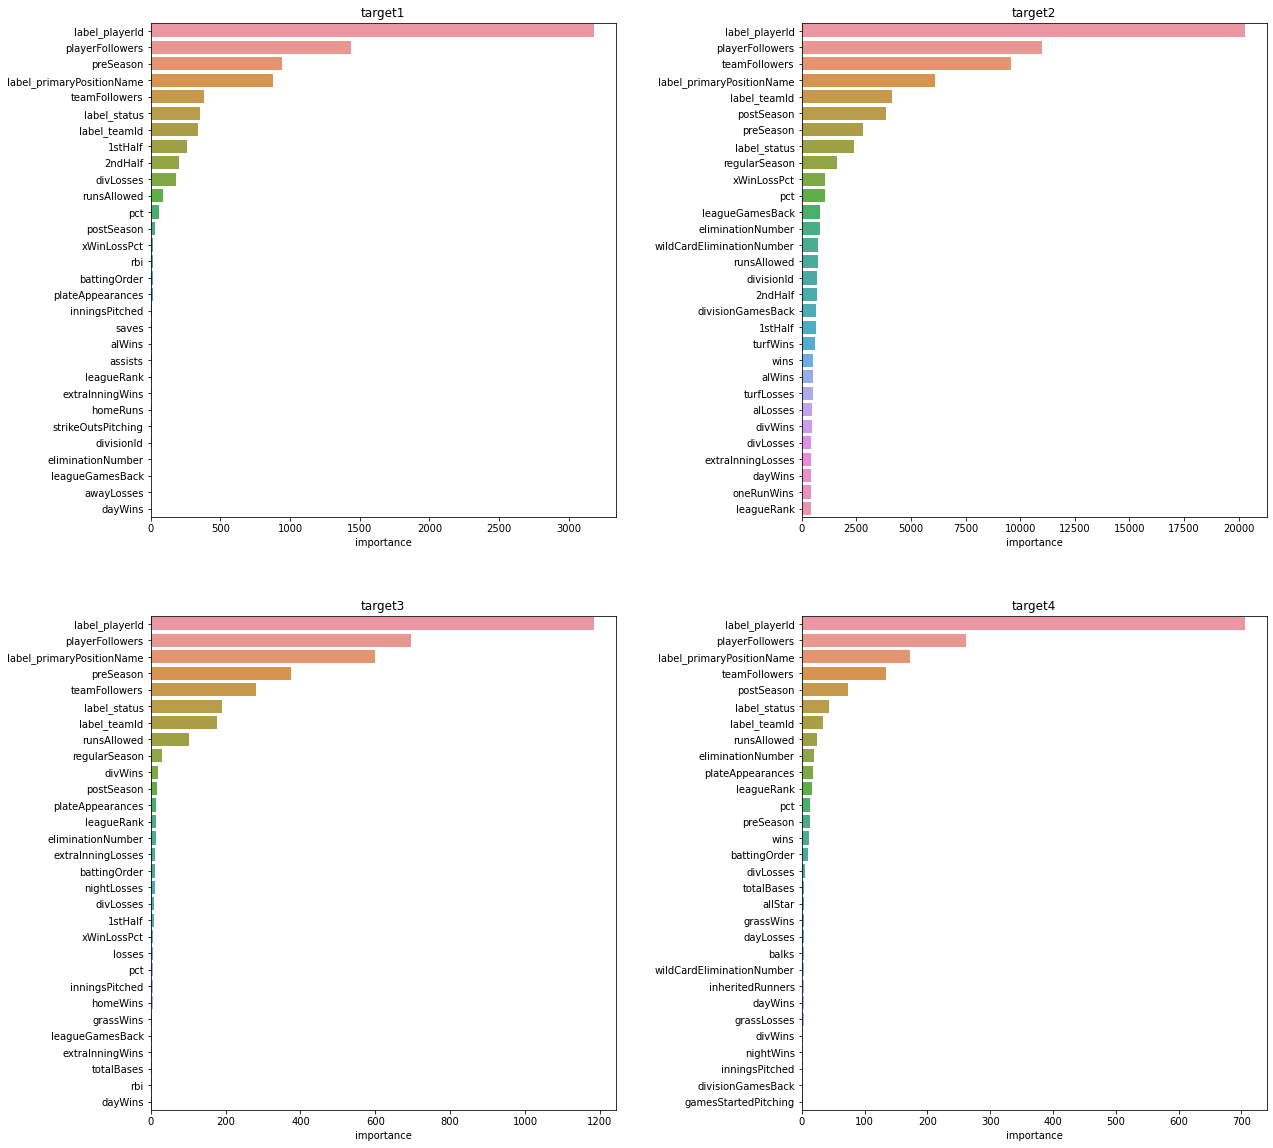

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
models = [model1, model2, model3, model4]

fig, axes = plt.subplots(2, 2, figsize=(20,20))
plt.subplots_adjust(wspace=0.4)
for i, model in enumerate(models):
    
    data = pd.DataFrame({'importance': model.feature_importances_, 'feature': feature_cols}).sort_values('importance', ascending = False)[0:30]

    ax = axes[ i // 2, i % 2]
    ax.yaxis.label.set_visible(False)
    ax.set_title('target' + str(i+1))
    
    sns.barplot(x='importance', y='feature', data=data, ax=ax)

plt.savefig(OUTPUT_DIR / 'feature_importance.png')


In [ ]:
# top50 importances
top_features = []
for i, model in enumerate(models):
    data = pd.DataFrame({'importance': model.feature_importances_, 'feature': feature_cols}).sort_values('importance', ascending = False)[0:50]
    top_features += data.feature.to_list()
top_features = list(set(top_features))
np.array(top_features)

array(['awayLosses', 'inheritedRunners', 'nightWins', 'oneRunLosses',
       'baseOnBallsPitching', 'leagueRank', 'putOuts', 'nightLosses',
       'runsAllowed', 'turfLosses', 'homeWins', 'nlLosses',
       'label_awardId', 'losses', 'label_teamId',
       'label_primaryPositionName', '2ndHalf', 'divWins', 'preSeason',
       'rbi', 'label_status', 'divisionChamp', 'divisionGamesBack',
       '1stHalf', 'assists', 'winsPitching', 'battersFaced', 'balks',
       'divisionRank', 'grassWins', 'nlWins', 'divLosses', 'divisionId',
       'alLosses', 'dayWins', 'allStar', 'extraInningLosses',
       'playerFollowers', 'stolenBases', 'label_streakCode',
       'pitchesThrown', 'alWins', 'dayLosses', 'lastTenWins',
       'gamesStartedPitching', 'battingOrder', 'totalBases', 'turfWins',
       'oneRunWins', 'wildPitches', 'pct', 'inheritedRunnersScored',
       'wins', 'label_playerId', 'teamFollowers', 'hits', 'groundOuts',
       'homeRuns', 'leagueGamesBack', 'saves', 'gamesPlayedBatting',


In [ ]:
len(top_features)

78

In [ ]:
# 0/0

# save mlflow

In [ ]:
if 'google.colab' in sys.modules:
    import os

    try:
        from google.colab import auth
        auth.authenticate_user()
    except ImportError:
        pass

    REPOSITORY_NAME = 'kaggleops-tutorial'
    PROJECT_ID = 'mlb-project-317407'
    BUCKET_NAME = 'mlb-bucket'

    os.environ["GCLOUD_PROJECT"] = PROJECT_ID

    from google.cloud import storage
    storage_client = storage.Client(project=PROJECT_ID)
    !rm -rf {REPOSITORY_NAME}
    !git clone https://github.com/yuooka/{REPOSITORY_NAME}.git
    !pip install -qr ./{REPOSITORY_NAME}/requirements.txt
    # cd ./{REPOSITORY_NAME}/src
    !gcloud config set project {PROJECT_ID}
    # !gsutil -mq cp -rn gs://{BUCKET_NAME}/mlruns /content/{BUCKET_NAME}/src

    blobs = storage_client.list_blobs(BUCKET_NAME)
    for blob in blobs:
        filepath = blob.name
        if filepath[:7]=="mlruns/" and len(filepath)!=7:
            os.makedirs("/".join(filepath.split("/")[:-1]), exist_ok=True)
            blob.download_to_filename(filepath)

Cloning into 'kaggleops-tutorial'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 69 (delta 22), reused 59 (delta 12), pack-reused 0
Unpacking objects: 100% (69/69), done.
     |████████████████████████████████| 12.0MB 11.7MB/s 
     |████████████████████████████████| 573kB 53.5MB/s 
     |████████████████████████████████| 174kB 64.6MB/s 
     |████████████████████████████████| 174kB 60.1MB/s 
     |████████████████████████████████| 153kB 64.6MB/s 
     |████████████████████████████████| 6.0MB 51.1MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 348kB 66.6MB/s 
     |████████████████████████████████| 901kB 44.8MB/s 
     |████████████████████████████████| 1.2MB 48.3MB/s 
     |████████████████████████████████| 5.6MB 38.3MB/s 
     |████████████████████████████████| 133kB 72.3MB/s 


In [ ]:
if 'google.colab' in sys.modules:
    import mlflow
    mlflow.start_run()
    mlflow.log_param("feature_cols", feature_cols)
    mlflow.log_param("params", params)
    mlflow.log_param("top_features", top_features)
    mlflow.log_metric('score', score)
    mlflow.log_metric('score1', score1)
    mlflow.log_metric('score2', score2)
    mlflow.log_metric('score3', score3)
    mlflow.log_metric('score4', score4)
    for i, model in enumerate(models):
        mlflow.log_param('feature_importance_' + str(i+1), model.feature_importances_)
    mlflow.log_artifact(OUTPUT_DIR / 'feature_importance.png')
    mlflow.end_run()

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):


In [ ]:
if 'google.colab' in sys.modules:
    !python ./{REPOSITORY_NAME}/src/mlproject.py
    # !gsutil -mq cp -rn /content/{REPOSITORY_NAME}/src/mlruns gs://{BUCKET_NAME}

    import glob

    files = [f for f in glob.glob("mlruns/**", recursive=True) if f[:7]=="mlruns/" and len(f)!=7]
    files_in_bucket = [f.name for f in storage_client.list_blobs(BUCKET_NAME)]
    bucket = storage_client.get_bucket(BUCKET_NAME)

    for f in files:
        try:
            if f not in files_in_bucket:
                blob = bucket.blob(f)
                blob.upload_from_filename(f)
        except:
            pass

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
Traceback (most recent call last):
  File "./kaggleops-tutorial/src/mlproject.py", line 17, in <module>
    exp_id = client.create_experiment(config['experiment_name'], artifact_location=f"gs://{config['bucket_name']}/artifacts")
  File "/usr/local/lib/python3.7/dist-packages/mlflow/tracking/client.py", line 161, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location)
  File "/usr/local/lib/python3.7/dist-packages/mlflow/tracking/_tracking_service/client.py", line 128, in create_experiment
    artifact_location=artifact_location,
  File "/usr/local/lib/python3.7/dist-packages/mlflow/store/tracking/file_store.py", line 239, in create_experiment
    self._validate_experiment_n